# Pipeline 1: Predicting Volatility and Evaluation

In [1]:
import os
import time
import random
import warnings
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import src.util as util
import src.rv as rv
import src.lstm as lstm

# Suppress warnings
warnings.filterwarnings("ignore")

# Reload modules to pick up any changes
importlib.reload(util)
importlib.reload(rv)
importlib.reload(lstm)

# Set random seed for reproducibility
SEED = 3888
np.random.seed(SEED)
random.seed(SEED)

# set seed for lstm
tf.random.set_seed(SEED)

In [6]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

KeyboardInterrupt: 

In [ ]:
# select only the first 100 time_id
subset_time_ids = snapshot_features_df['time_id'].unique()[:5]
subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()

In [ ]:
importlib.reload(util)
#  Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(subset_snapshot_df)

## RV OLS Baseline

=== HAR-RV OLS Baseline Evaluation ===
MSE: 0.00000000
RMSE: 0.00003585
QLIKE: 0.3222
Directional Accuracy: 0.5180
Average inference time per sample: 0.000040 seconds
✅ Model saved to out/rv/rv_ols.pkl


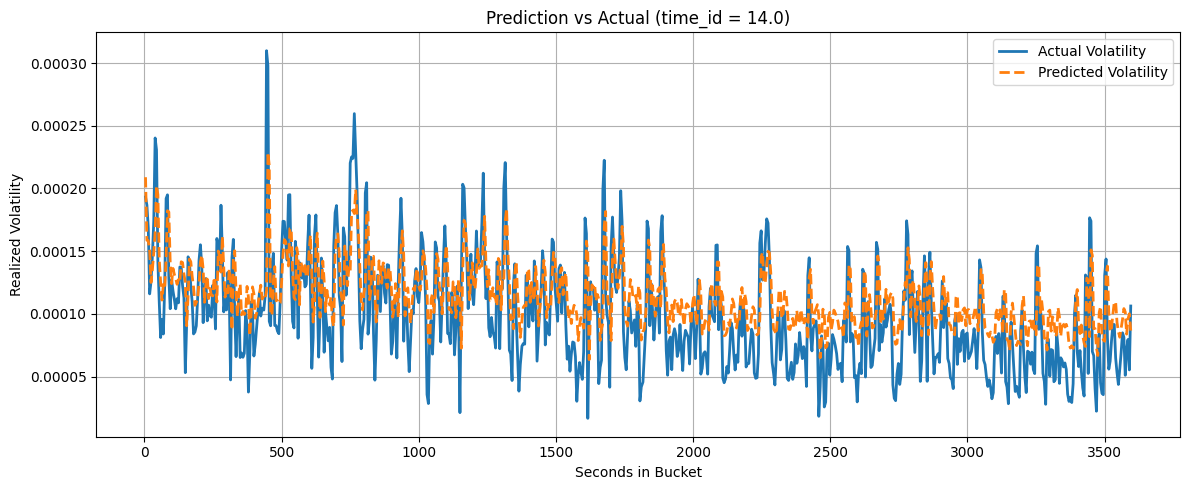

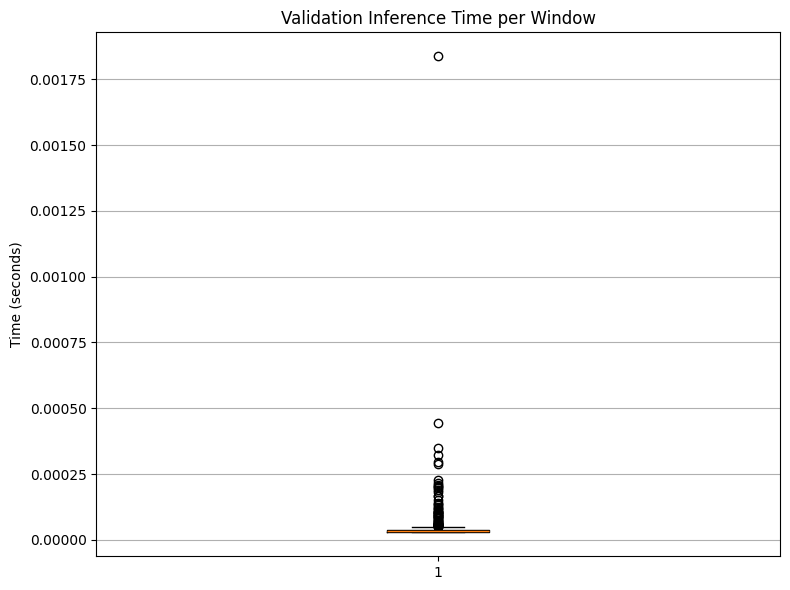

,time_id,start_time,y_true,y_pred,inference_time
0,14.0,4.0,0.000193,0.000209,0.000090
1,14.0,9.0,0.000187,0.000159,0.000064
2,14.0,14.0,0.000169,0.000158,0.000055
3,14.0,19.0,0.000116,0.000150,0.000053
4,14.0,24.0,0.000126,0.000125,0.000053
5,14.0,29.0,0.000146,0.000135,0.000052
6,14.0,34.0,0.000174,0.000149,0.000072
7,14.0,39.0,0.000240,0.000165,0.000051
8,14.0,44.0,0.000231,0.000202,0.000050
9,14.0,49.0,0.000141,0.000195,0.000050


In [ ]:
importlib.reload(rv)

model_rv_ols, test_df_ols = rv.ols(rolling_features_df)

# Plot predicted vs. actual volatility for one time_id
util.plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(test_df_ols)

display(test_df_ols.head(10))

## LSTM

### LSTM Baseline

In [ ]:
importlib.reload(lstm)

# --- Run LSTM Baseline ---
model_lstm_baseline, history_lstm_baseline, val_df_lstm_baseline = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=['wap', 'log_return'],
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='baseline'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.9670 - val_loss: 0.8451 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.9312 - val_loss: 0.9084 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.8604 - val_loss: 0.7321 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.8056 - val_loss: 0.5870 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7540 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7424 - val_loss: 0.5096 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7383 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7359 - val_loss: 0.4942 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7343 - val_loss: 

Validation MSE: 0.00000000
Validation RMSE: 0.00004232
Validation QLIKE: 0.3961
Directional Acc: 0.3657
Average inference time per window: 0.032856 seconds
Model & scalers saved to out/lstm


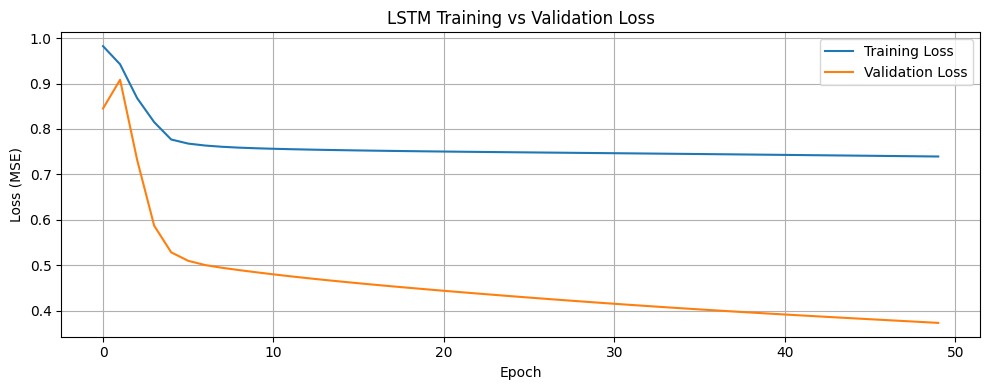

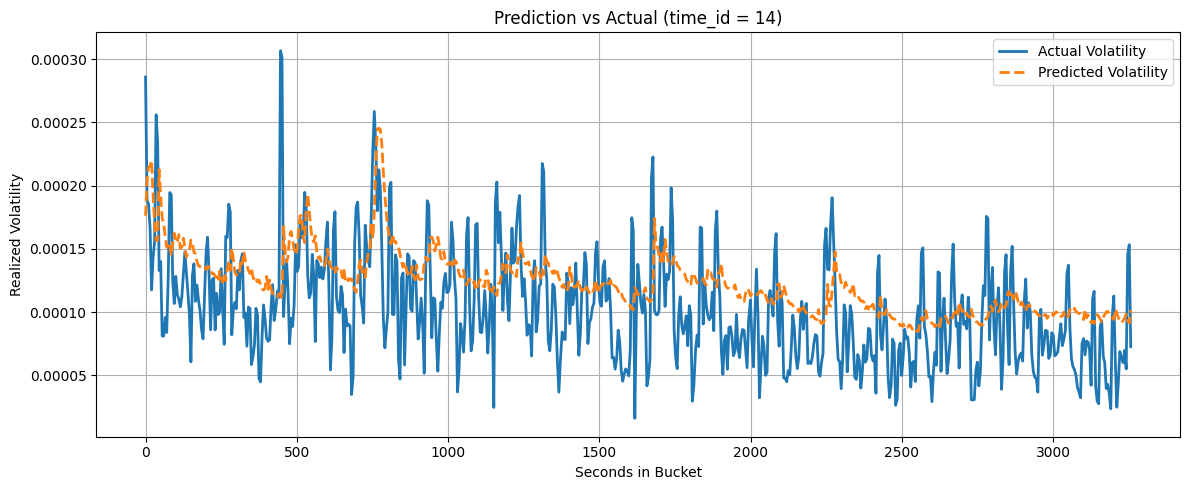

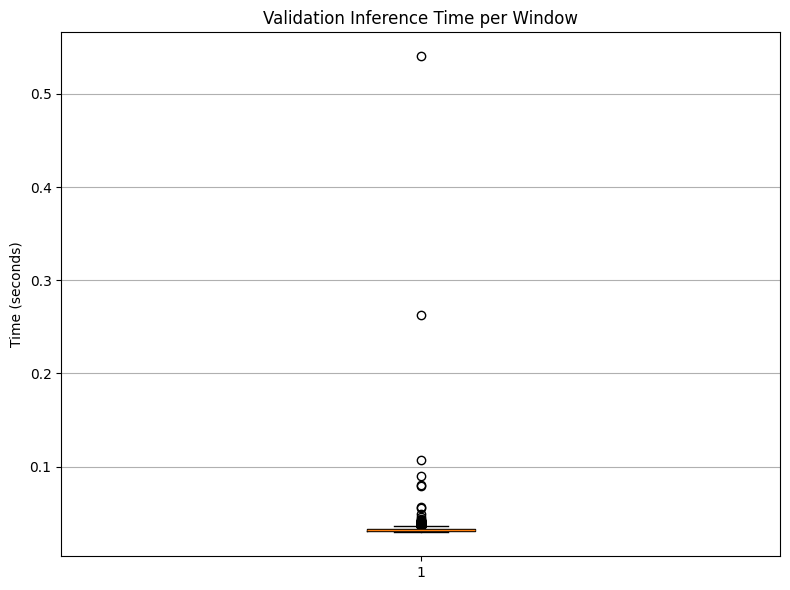

,time_id,start_time,y_true,y_pred,inference_time
0,14,0.0,0.000286,0.000176,0.540559
1,14,5.0,0.000188,0.000205,0.034921
2,14,10.0,0.000185,0.000214,0.035679
3,14,15.0,0.000166,0.000215,0.033417
4,14,20.0,0.000118,0.000220,0.032998
5,14,25.0,0.000144,0.000193,0.034423
6,14,30.0,0.000156,0.000170,0.032971
7,14,35.0,0.000256,0.000157,0.032453
8,14,40.0,0.000234,0.000157,0.034502
9,14,45.0,0.000133,0.000213,0.032566


In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_baseline)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_baseline,
    time_id=val_df_lstm_baseline['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_baseline)

display(val_df_lstm_baseline.head(10))

### LSTM With Features

In [ ]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

# --- Run LSTM Baseline ---
model_lstm_features, history_lstm_features, val_df_lstm_features = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='additional_features'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.9404 - val_loss: 0.5201 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8318 - val_loss: 0.3994 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8099 - val_loss: 0.3670 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7932 - val_loss: 0.3453 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.7775 - val_loss: 0.3409 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7675 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7612 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7558 - val_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7506 - val_loss: 

Validation MSE: 0.00000000
Validation RMSE: 0.00004046
Validation QLIKE: 0.3822
Directional Acc: 0.4228
Average inference time per window: 0.032021 seconds
Model & scalers saved to out/lstm


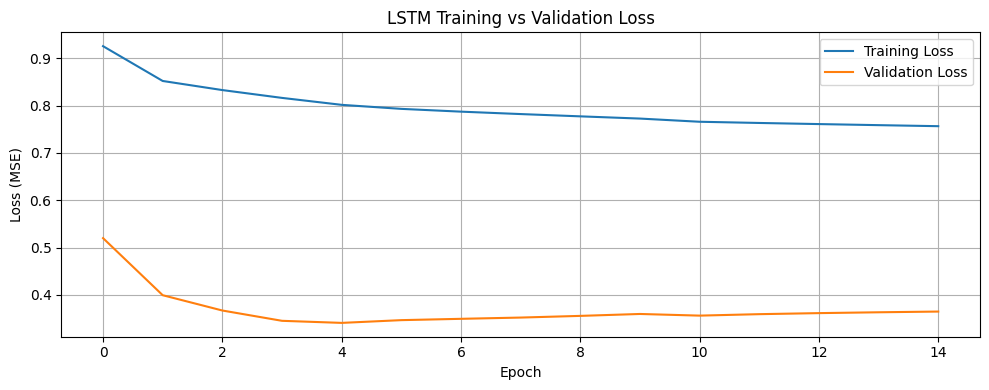

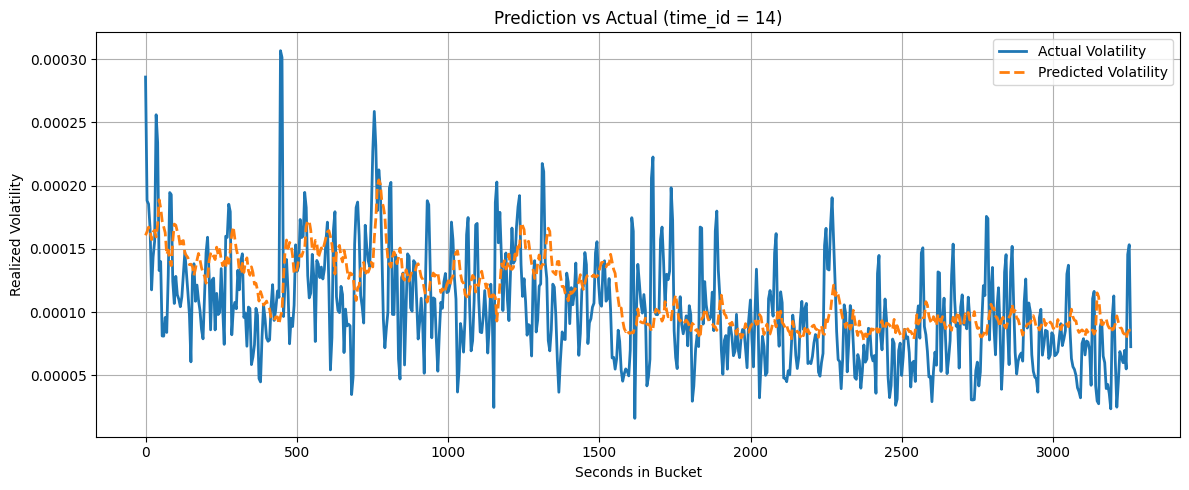

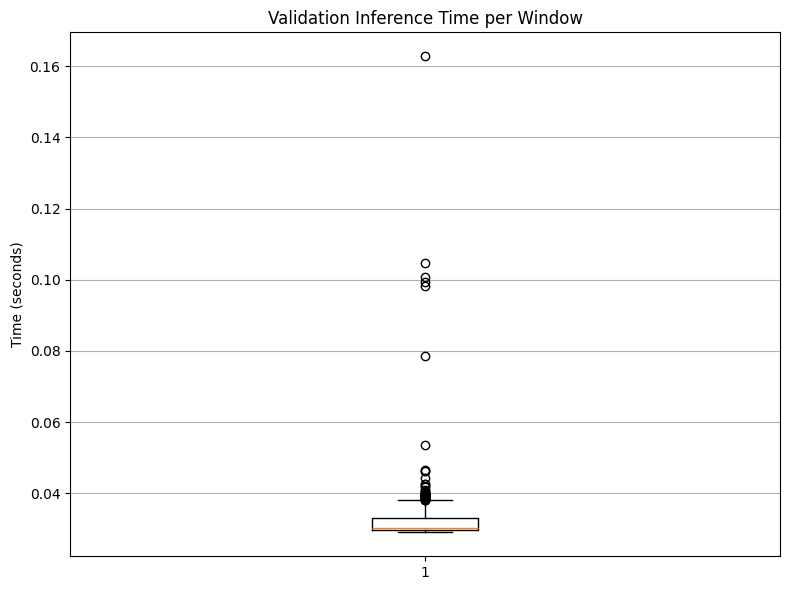

,time_id,start_time,y_true,y_pred,inference_time
0,14,0.0,0.000286,0.000161,0.104821
1,14,5.0,0.000188,0.000164,0.035891
2,14,10.0,0.000185,0.000167,0.035220
3,14,15.0,0.000166,0.000164,0.035258
4,14,20.0,0.000118,0.000157,0.037052
5,14,25.0,0.000144,0.000163,0.035133
6,14,30.0,0.000156,0.000165,0.035833
7,14,35.0,0.000256,0.000159,0.035038
8,14,40.0,0.000234,0.000169,0.038045
9,14,45.0,0.000133,0.000189,0.036456


In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_features)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_features,
    time_id=val_df_lstm_features['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

display(val_df_lstm_features.head(10))

## Advanced LSTM Model

In [ ]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_advanced, history_lstm_advanced, val_df_lstm_advanced = lstm.advanced(
    subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    model_name='advanced'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - loss: 0.9337 - val_loss: 0.5344 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 0.9812 - val_loss: 0.6718 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.3151 - val_loss: 0.9286 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.2305 - val_loss: 0.6662 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 220ms/step - loss: 1.1969 - val_loss: 0.5519 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - loss: 1.1402 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - loss: 1.1482 - val_loss: 0.6520 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - loss: 1.0906 - val_loss: 0.6414 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - loss: 1

Final Model MSE: 0.00000000
Final Model RMSE: 0.00005066
Final Model QLIKE: 0.5020
Directional Acc: 0.4699
Avg Inference Time: 0.061351s
Saved final model & scalers to <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>


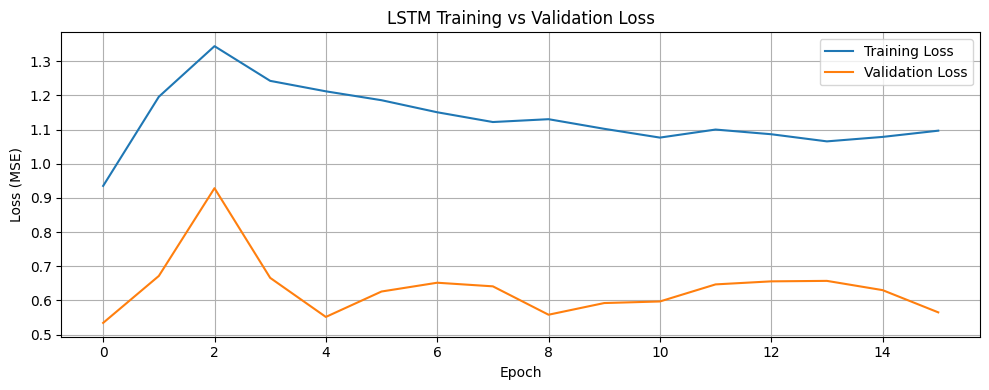

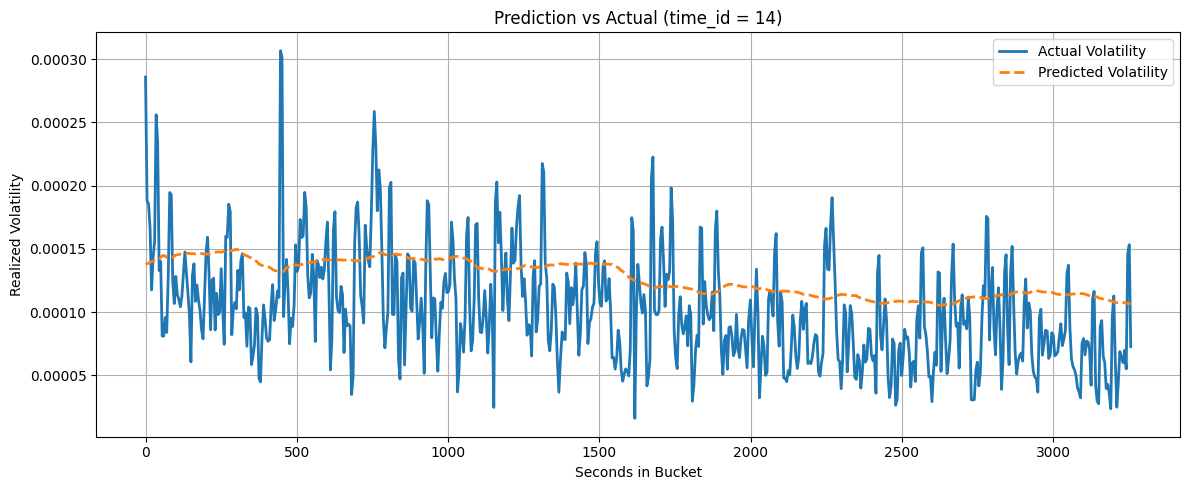

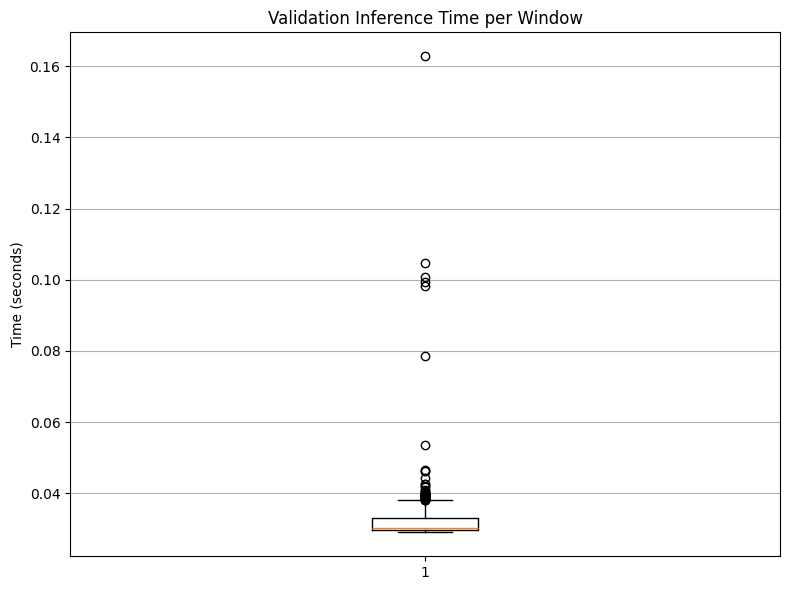

In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_advanced)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_advanced,
    time_id=val_df_lstm_advanced['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

## In Sample Evaluation

                      model           mse      rmse     qlike  \
0              ols_baseline  1.285060e-09  0.000036  0.322214   
1             lstm_baseline  1.791092e-09  0.000042  0.396131   
2  lstm_additional_features  1.637124e-09  0.000040  0.382185   
3             lstm_advanced  2.566615e-09  0.000051  0.501960   

   directional_accuracy  avg_inference_time  
0              0.517975            0.000040  
1              0.365741            0.032856  
2              0.422840            0.032021  
3              0.469907            0.061351  


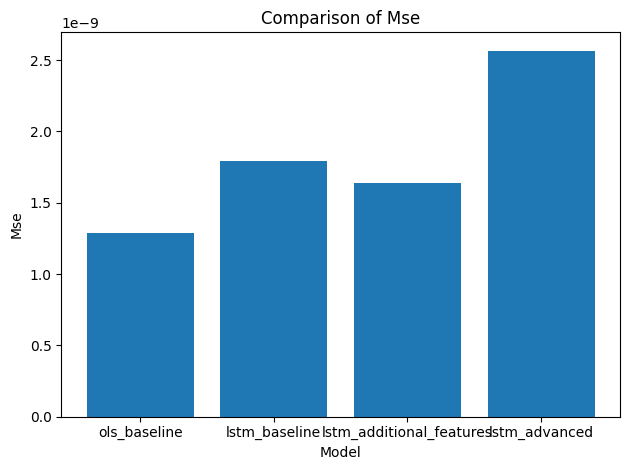

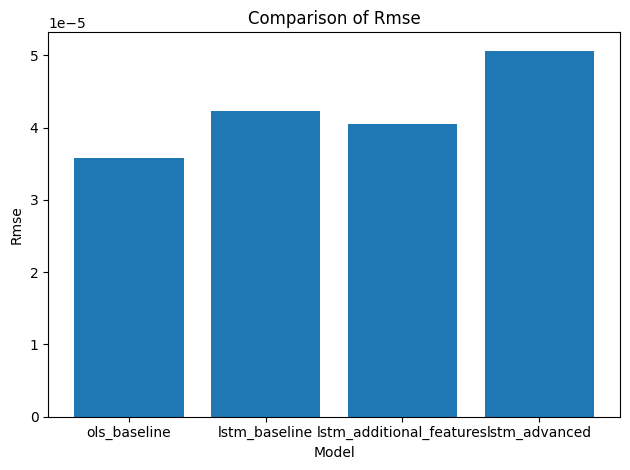

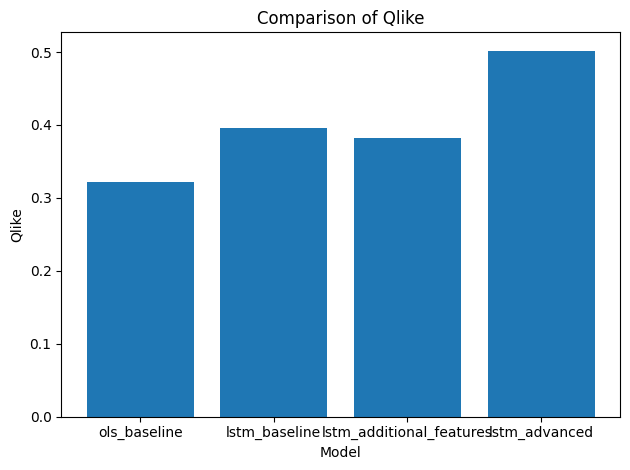

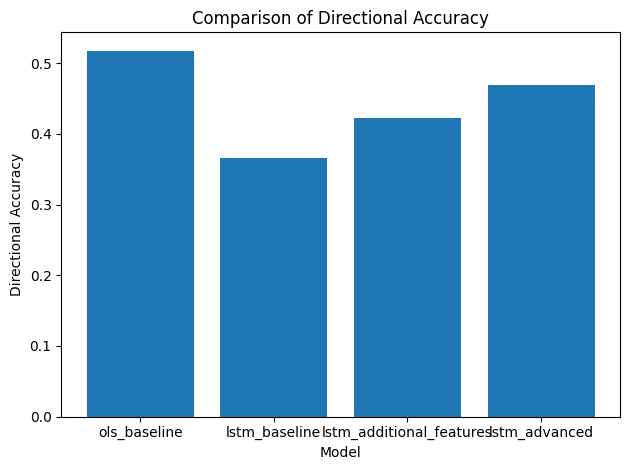

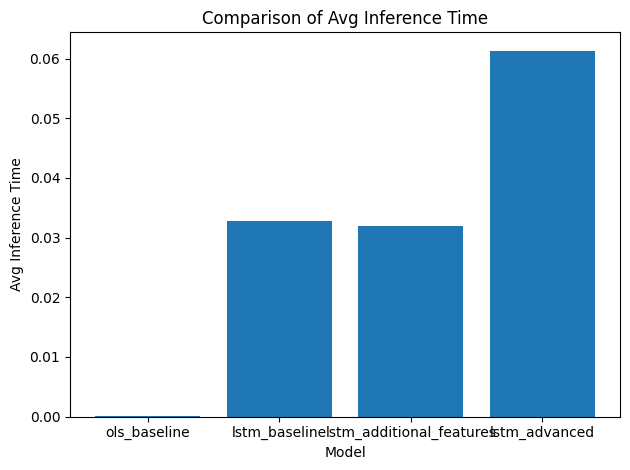

In [ ]:
metrics = []
for name, val_df in [
        ('ols_baseline', test_df_ols),
        ('lstm_baseline', val_df_lstm_baseline),
        ('lstm_additional_features', val_df_lstm_features),
        ('lstm_advanced', val_df_lstm_advanced)
    ]:
    y_true = val_df['y_true'].values
    y_pred = val_df['y_pred'].values
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    qlike = util.qlike_loss(y_true, y_pred)
    directional_acc = util.directional_accuracy(y_true, y_pred)
    avg_inf_time = val_df['inference_time'].mean()
    metrics.append({
        'model': name,
        'mse': mse,
        'rmse': rmse,
        'qlike': qlike,
        'directional_accuracy': directional_acc,
        'avg_inference_time': avg_inf_time
    })

metric_df = pd.DataFrame(metrics)
print(metric_df)

# -------------------------------------------------------------
## Evaluation Metrics
# -------------------------------------------------------------
# Visualise each metric in its own bar chart

# List of metrics to plot (excluding model name)
plot_metrics = ['mse', 'rmse', 'qlike', 'directional_accuracy', 'avg_inference_time']

for metric in plot_metrics:
    plt.figure()
    plt.bar(metric_df['model'], metric_df[metric])
    plt.title(f'Comparison of {metric.replace("_", " ").title()}')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

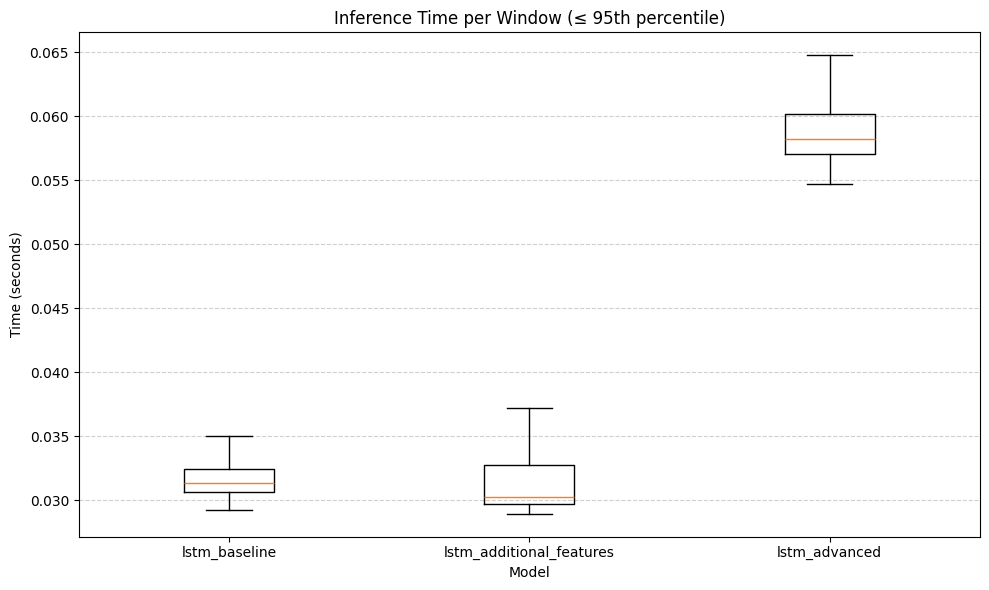

In [ ]:
# Create a dictionary of DataFrames for each model
val_dfs = {
    'lstm_baseline': val_df_lstm_baseline,
    'lstm_additional_features': val_df_lstm_features,
    'lstm_advanced': val_df_lstm_advanced
}

util.plot_side_by_side_inference_boxplots(val_dfs,
                                     inference_col='inference_time',
                                     percentile=95)

## Out of Sample Evaluation

### Highly Correlated Stocks: ID-104919

In [2]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_high_cor_stock = combined_df[combined_df["stock_id"] == 104919].copy()

snapshot_features_df_high_cor = util.create_snapshot_features(df_high_cor_stock)
snapshot_features_df_high_cor = snapshot_features_df_high_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_high_cor['time_id'].unique()[:10]
subset_snapshot_df_high_cor = snapshot_features_df[snapshot_features_df_high_cor['time_id'].isin(subset_time_ids)].copy()

NameError: name 'snapshot_features_df' is not defined

In [ ]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'

basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_high_cor, oos_metrics_high_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_high_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_high_cor)
print(val_df_oos_high_cor.head())


Out-of-Sample Metrics: {'mse': 3.276007473664776e-08, 'rmse': 0.00018099744400584158, 'qlike': 4.183757792128442, 'directional_accuracy': 0.519361833952912, 'avg_inference_time': 0.06196931018536619}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.398865
1        6      1802.0  0.000129  0.000106        0.063055
2        6      1805.0  0.000329  0.000106        0.062352
3        6      1807.0  0.000446  0.000105        0.062805
4        6      1810.0  0.000438  0.000106        0.058524


### Lowly Correlated Stocks: ID-22753

In [ ]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_low_cor_stock = combined_df[combined_df["stock_id"] == 22753].copy()

snapshot_features_df_low_cor = util.create_snapshot_features(df_low_cor_stock)
snapshot_features_df_low_cor = snapshot_features_df_low_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_low_cor['time_id'].unique()[:10]
subset_snapshot_df_low_cor = snapshot_features_df_low_cor[snapshot_features_df_low_cor['time_id'].isin(subset_time_ids)].copy()

In [ ]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_low_cor, oos_metrics_low_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_low_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_low_cor)
print(val_df_oos_low_cor.head())

Out-of-Sample Metrics: {'mse': 3.320566820245771e-08, 'rmse': 0.00018222422507026257, 'qlike': 4.236690438652568, 'directional_accuracy': 0.5194151096669375, 'avg_inference_time': 0.0564814600901018}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.338168
1        6      1802.0  0.000129  0.000106        0.056722
2        6      1805.0  0.000329  0.000106        0.056631
3        6      1807.0  0.000446  0.000105        0.056182
4        6      1810.0  0.000438  0.000106        0.056672


In [ ]:
insample_adv = metric_df.loc[metric_df['model'] == 'lstm_advanced'].iloc[0].to_dict()

comparison_df = pd.DataFrame([
    {'dataset': 'in_sample',             **insample_adv},
    {'dataset': 'out_sample_highcor',   **oos_metrics_high_cor},
    {'dataset': 'out_sample_lowcor',    **oos_metrics_low_cor},
]).set_index('dataset')

display(comparison_df)


,model,mse,rmse,qlike,directional_accuracy,avg_inference_time
dataset,,,,,,
in_sample,lstm_advanced,2.566615e-09,0.000051,0.501960,0.469907,0.061351
out_sample_highcor,NaN,3.276007e-08,0.000181,4.183758,0.519362,0.061969
out_sample_lowcor,NaN,3.320567e-08,0.000182,4.236690,0.519415,0.056481


# Pipeline 2: Predicting Bid-Ask Spread and Quoting Strategy

**1. Data Preparation:** Our data is prepared by using our Pipeline 1's LSTM code to predict volatility values. Then we divide the data into 330s time buckets and merge predicted volatility (***at time t+1***) with features like "wap", "spread_pct", "imbalance", "depth_ratio", "log_return", "bid_ask_spread" (***at time t***). For our dataset for prediction, we shift "bid_ask_spread" by 1 row to simulate time t+1.

**2. BAS Model Prediction:** We utilize xgBoost model to train, using 80/20 split and GridSearchCV to find the best combination of parameters for the job,

**3. Mid Price Prediction:** We used a simple linear regression model to predict the approximate mid price

**4. Quoting Strategy and Evaluation:** Then suggested quoting strategy is simple: Bid/Ask = Mid Price -/+ BAS/2. We evaluated the performance of our strategy. See the evaluation tactic below at section "Trading at Predicted Quoting Prices vs Actual Prices"

## Data Preperation

In [3]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df['time_id'].unique()
subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()
subset_snapshot_df = subset_snapshot_df[subset_snapshot_df['time_id'] <= 50]

In [ ]:
import pandas as pd
import numpy as np
import joblib
import src.util as util
from tensorflow.keras.models import load_model


importlib.reload(util)

# --- Load model and scaler ---
model = load_model("out/lstm/moe_full.h5", custom_objects={"mse": "mse"})
scaler = joblib.load("out/lstm/moe_scalers_full.pkl")

# --- Define features used by LSTM ---
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore", "volume_imbalance"]

val_df, _ = util.out_of_sample_evaluation("out/lstm/moe_full.h5", "out/lstm/moe_scalers_full.pkl", subset_snapshot_df, basic_features)
val_df.to_csv("predictions_spy.csv", index=False)
val_df

,time_id,start_time,y_true,y_pred,inference_time
0,6,1800.0,0.000235,0.000161,0.317032
1,6,1802.0,0.000356,0.000256,0.056203
2,6,1805.0,0.000357,0.000251,0.053858
3,6,1807.0,0.000162,0.000277,0.058662
4,6,1810.0,0.000179,0.000273,0.054181
...,...,...,...,...,...
29330,50,3237.0,0.000059,0.000065,0.054208
29331,50,3242.0,0.000048,0.000061,0.056594
29332,50,3247.0,0.000028,0.000064,0.054469
29333,50,3252.0,0.000017,0.000057,0.057181


## BAS Prediction Model using XGBoost

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt

# --- Step 0: Load LSTM predictions ---
if os.path.exists("predictions_spy.csv"):
    pred_df = pd.read_csv("predictions_spy.csv")
    pred_df = pred_df.rename(columns={"y_pred": "predicted_volatility_lead1"})
else:
    raise FileNotFoundError("predictions_spy.csv not found.")

# --- Step 1: Create rolling windows (330s horizon, 10s step) ---
df = subset_snapshot_df.copy()
df = df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

WINDOW_SIZE = 330
STEP = 10
rolling_rows = []

for time_id, group in df.groupby("time_id"):
    group = group.reset_index(drop=True)
    for i in range(0, len(group) - WINDOW_SIZE + 1, STEP):
        window = group.iloc[i:i + WINDOW_SIZE]
        start_time = window.iloc[0]['seconds_in_bucket']
        agg = {
            'time_id': time_id,
            'start_time': start_time,
            'wap': window['wap'].mean(),
            'spread_pct': window['spread_pct'].mean(),
            'imbalance': window['imbalance'].mean(),
            'depth_ratio': window['depth_ratio'].mean(),
            'log_return': window['log_return'].mean(),
            'bid_ask_spread': window['bid_ask_spread'].mean()
        }
        rolling_rows.append(agg)

rolling_df = pd.DataFrame(rolling_rows)

# --- Step 2: Create lead target and merge predictions ---
rolling_df['bid_ask_spread_lead1'] = rolling_df.groupby('time_id')['bid_ask_spread'].shift(-1)
rolling_df = rolling_df.dropna().reset_index(drop=True)
merged_df_spy = pd.merge(pred_df, rolling_df, on=['time_id', 'start_time'], how='inner')

# --- Step 3: Prepare features and target ---
y = merged_df_spy["bid_ask_spread_lead1"]
X = merged_df_spy.drop(columns=["time_id", "start_time", "bid_ask_spread_lead1"])

# --- Step 4: Train-test split ---
cutoff = int(len(merged_df_spy) * 0.8)
X_train, X_test = X.iloc[:cutoff].copy(), X.iloc[cutoff:].copy()
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

# --- Step 5: Feature scaling ---
scaler = StandardScaler()
for col in ['spread_pct']:
    X_train[f"{col}_scaled"] = scaler.fit_transform(X_train[[col]])
    X_test[f"{col}_scaled"] = scaler.transform(X_test[[col]])

# --- Step 6: Feature selection ---
feature_cols = [
    'predicted_volatility_lead1', 'spread_pct_scaled',
    'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread'
]
X_train_final = X_train[feature_cols]
X_test_final = X_test[feature_cols]

# --- Step 7: Model training ---
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 6],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
grid_search = GridSearchCV(
    xgb, param_grid, cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1
)
grid_search.fit(X_train_final, y_train)
best_model = grid_search.best_estimator_

# --- Step 8: Evaluation ---
y_pred = best_model.predict(X_test_final)

print("🔍 Model Evaluation:")
print(f"MSE:  {mean_squared_error(y_test, y_pred):.6f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.6f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")
print(f"R²:   {r2_score(y_test, y_pred):.4f}")

joblib.dump(best_model, "bid_ask_spread_model.pkl")


Fitting 5 folds for each of 256 candidates, totalling 1280 fits
🔍 Model Evaluation:
MSE:  0.000000
MAE:  0.000072
RMSE: 0.000091
R²:   0.9940


['bid_ask_spread_model.pkl']

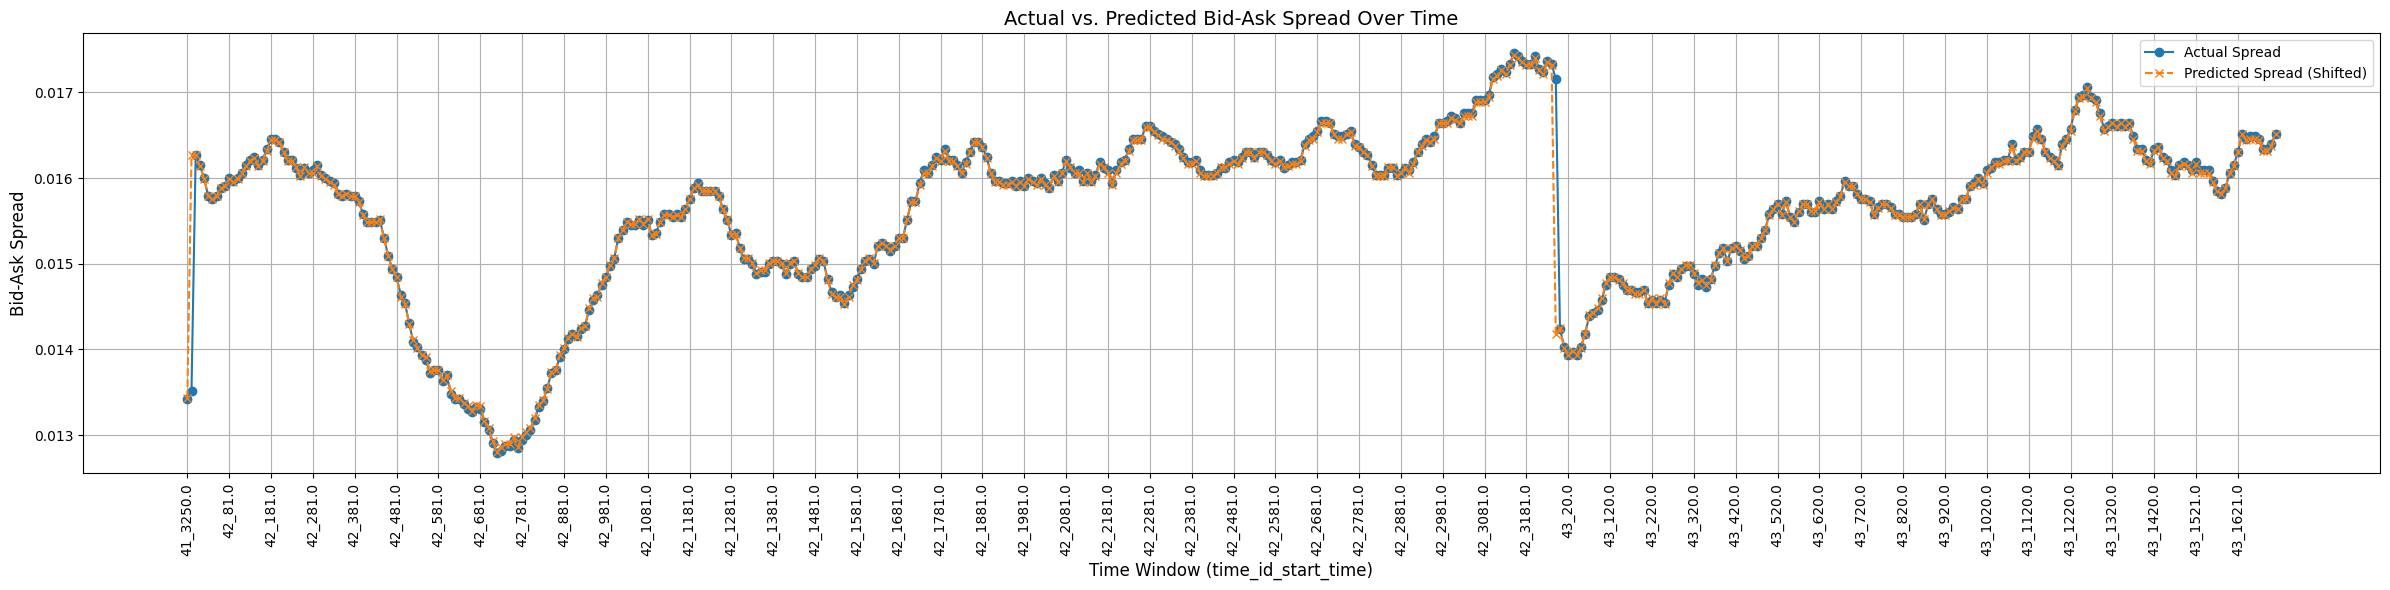

In [ ]:
import matplotlib.pyplot as plt

# --- Step 1: Create comparison DataFrame ---
comparison_df = pd.DataFrame({
    "time_id": merged_df_spy.loc[y_test.index, "time_id"].values,
    "start_time": merged_df_spy.loc[y_test.index, "start_time"].values,
    "actual_bid_ask_spread": y_test.values,
    "predicted_bid_ask_spread": y_pred
})

# --- Step 2: Align predictions (optional shift) ---
comparison_df['predicted_bid_ask_spread_shifted'] = comparison_df['predicted_bid_ask_spread'].shift(-1)
comparison_df = comparison_df.dropna().reset_index(drop=True)

# --- Step 3: Generate readable time label for x-axis ---
comparison_df['window_label'] = comparison_df['time_id'].astype(str) + "_" + comparison_df['start_time'].astype(str)

# --- Step 4: Slice for clarity (optional) ---
subset = comparison_df.head(500).copy()  # Adjust if you want a different slice

# --- Step 5: Plot ---
plt.figure(figsize=(24, 6))
plt.plot(subset['window_label'], subset['actual_bid_ask_spread'], label='Actual Spread', marker='o', linewidth=1.5)
plt.plot(subset['window_label'], subset['predicted_bid_ask_spread_shifted'], label='Predicted Spread (Shifted)', linestyle='--', marker='x', linewidth=1.5)

plt.title("Actual vs. Predicted Bid-Ask Spread Over Time", fontsize=14)
plt.xlabel("Time Window (time_id_start_time)", fontsize=12)
plt.ylabel("Bid-Ask Spread", fontsize=12)
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Evaluation

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Ensure y_test and predictions are defined ---
y_true = y_test  # or y_test_final if you're using that convention
y_pred_xgb = best_model.predict(X_test_final)

# --- Baseline: predict the previous observed bid-ask spread as the next one ---
# You must make sure 'bid_ask_spread' is available in X_test
baseline_pred = X_test['bid_ask_spread'].values

# --- XGBoost performance ---
mse_xgb = mean_squared_error(y_true, y_pred_xgb)
mae_xgb = mean_absolute_error(y_true, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_true, y_pred_xgb)

# --- Baseline performance ---
mse_base = mean_squared_error(y_true, baseline_pred)
mae_base = mean_absolute_error(y_true, baseline_pred)
rmse_base = np.sqrt(mse_base)
r2_base = r2_score(y_true, baseline_pred)

# --- Display comparison ---
print("\n📊 Model Performance Comparison:")
print("------------------------------------------------------")
print(f"{'Metric':<10} | {'XGBoost':>10} | {'Baseline':>10}")
print("------------------------------------------------------")
print(f"{'MSE':<10} | {mse_xgb:10.6f} | {mse_base:10.6f}")
print(f"{'MAE':<10} | {mae_xgb:10.6f} | {mae_base:10.6f}")
print(f"{'RMSE':<10} | {rmse_xgb:10.6f} | {rmse_base:10.6f}")
print(f"{'R²':<10} | {r2_xgb:10.4f} | {r2_base:10.4f}")



📊 Model Performance Comparison:
------------------------------------------------------
Metric     |    XGBoost |   Baseline
------------------------------------------------------
MSE        |   0.000000 |   0.000000
MAE        |   0.000072 |   0.000070
RMSE       |   0.000091 |   0.000089
R²         |     0.9940 |     0.9942


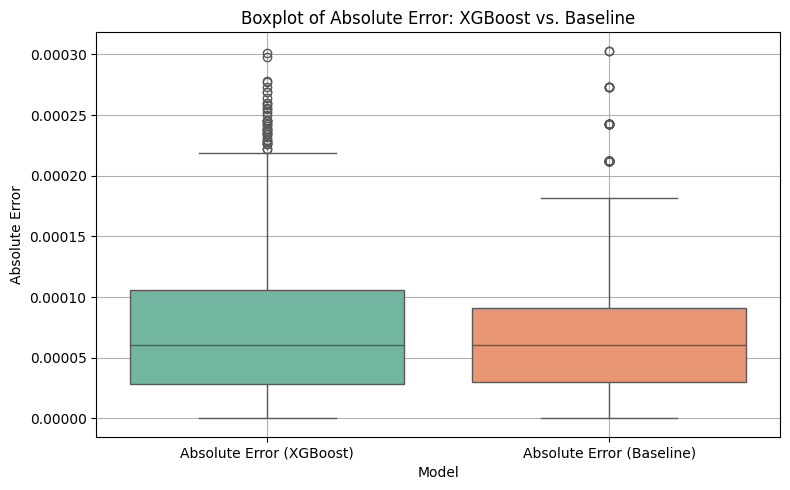

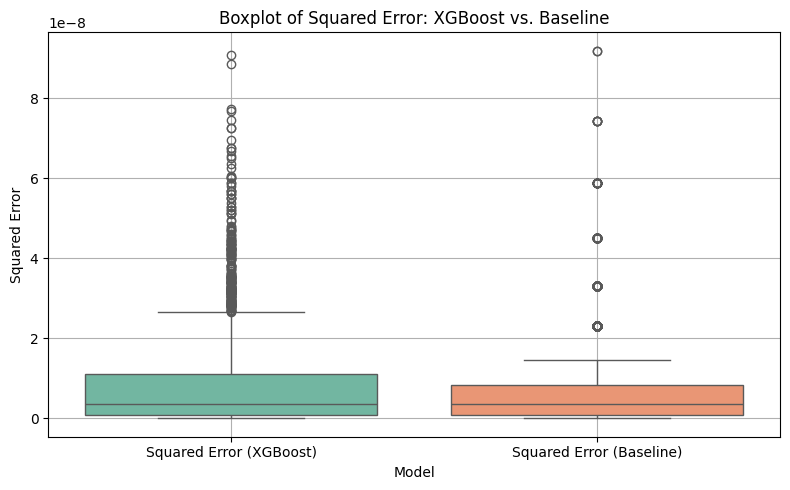

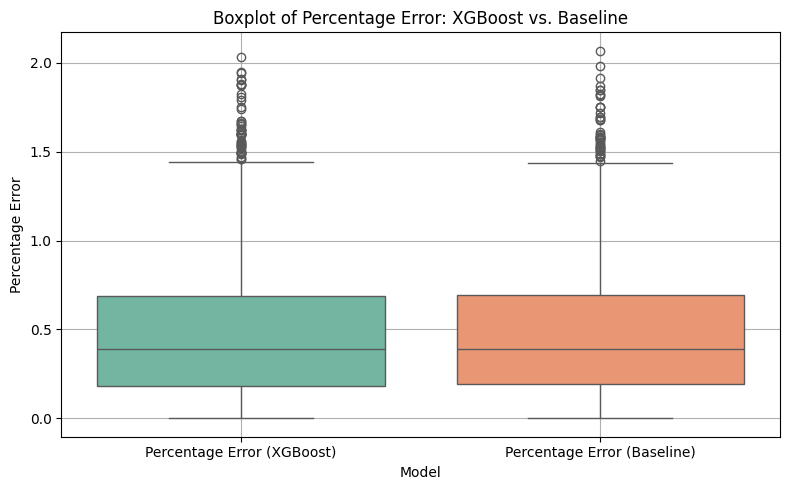

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Ensure predictions and targets are NumPy arrays ---
y_true = np.array(y_test)  # or y_test_final
y_pred_xgb = np.array(y_pred)  # best_model.predict(X_test_final)
y_pred_base = np.array(X_test['bid_ask_spread'].values)  # baseline: last known spread

# --- Construct error metrics ---
metrics_df = pd.DataFrame({
    "Absolute Error (XGBoost)": np.abs(y_true - y_pred_xgb),
    "Absolute Error (Baseline)": np.abs(y_true - y_pred_base),
    "Squared Error (XGBoost)": (y_true - y_pred_xgb) ** 2,
    "Squared Error (Baseline)": (y_true - y_pred_base) ** 2,
    "Percentage Error (XGBoost)": np.abs((y_true - y_pred_xgb) / y_true) * 100,
    "Percentage Error (Baseline)": np.abs((y_true - y_pred_base) / y_true) * 100,
})

# --- Melt for boxplot ---
melt_abs = metrics_df[["Absolute Error (XGBoost)", "Absolute Error (Baseline)"]].melt(
    var_name="Model", value_name="Absolute Error"
)
melt_sq = metrics_df[["Squared Error (XGBoost)", "Squared Error (Baseline)"]].melt(
    var_name="Model", value_name="Squared Error"
)
melt_pct = metrics_df[["Percentage Error (XGBoost)", "Percentage Error (Baseline)"]].melt(
    var_name="Model", value_name="Percentage Error"
)

# --- Plot Absolute Error ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=melt_abs, x="Model", y="Absolute Error", palette="Set2")
plt.title("Boxplot of Absolute Error: XGBoost vs. Baseline")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Squared Error ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=melt_sq, x="Model", y="Squared Error", palette="Set2")
plt.title("Boxplot of Squared Error: XGBoost vs. Baseline")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Percentage Error (if safe) ---
if not np.any(y_true == 0):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=melt_pct, x="Model", y="Percentage Error", palette="Set2")
    plt.title("Boxplot of Percentage Error: XGBoost vs. Baseline")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipped percentage error plot due to risk of division by zero.")


In [77]:
import time

# --- Measure prediction time ---
start_time = time.time()

y_pred_best = best_model.predict(X_test_final)

end_time = time.time()
prediction_time = end_time - start_time

print(f"\nPrediction Time: {prediction_time:.6f} seconds")
print(f"Average Time per Sample: {prediction_time / len(X_test_final):.6f} seconds")



Prediction Time: 0.006796 seconds
Average Time per Sample: 0.000002 seconds


## Quoting Price

In [51]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

# Load predictions (from your LSTM volatility model)
pred_df = pd.read_csv("predictions_spy.csv").rename(columns={"y_pred": "predicted_volatility_lead1"})

# Copy snapshot data (from your main subset)
df = subset_snapshot_df.copy()
df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
df = df[df['stock_id'] == 50200].sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Compute rolling windows to match your spread model
WINDOW_SIZE = 330
STEP = 10
rolling_rows = []

for time_id, group in df.groupby("time_id"):
    group = group.reset_index(drop=True)
    for i in range(0, len(group) - WINDOW_SIZE + 1, STEP):
        window = group.iloc[i:i + WINDOW_SIZE]
        start_time = window.iloc[0]['seconds_in_bucket']
        agg = {
            'time_id': time_id,
            'start_time': start_time,
            'mid_price': window['mid_price'].mean(),
            'wap': window['wap'].mean(),
            'spread_pct': window['spread_pct'].mean(),
            'imbalance': window['imbalance'].mean(),
            'depth_ratio': window['depth_ratio'].mean(),
            'log_return': window['log_return'].mean(),
            'bid_ask_spread': window['bid_ask_spread'].mean()
        }
        rolling_rows.append(agg)

rolling_df = pd.DataFrame(rolling_rows)

# Add lead spread (target in original spread model)
rolling_df['bid_ask_spread_lead1'] = rolling_df.groupby('time_id')['bid_ask_spread'].shift(-1)
rolling_df = rolling_df.dropna().reset_index(drop=True)

# Merge predicted volatility
merged_df = pd.merge(pred_df, rolling_df, on=['time_id', 'start_time'], how='inner')

# Take one random row for quoting
row = merged_df.sample(1, random_state=42).copy()
row_index = row.index[0]
next_index = row_index + 1

# Predict mid-price using lag (current mid_price)
pred_mid_price = row['mid_price'].values[0]

# Standardize spread_pct for model
scaler = StandardScaler()
row['spread_pct_scaled'] = scaler.fit_transform(row[['spread_pct']])

# Load trained spread model
spread_model = joblib.load("bid_ask_spread_model.pkl")

# Select features and predict spread
spread_features = [
    'predicted_volatility_lead1',
    'spread_pct_scaled',
    'wap',
    'imbalance',
    'depth_ratio',
    'log_return',
    'bid_ask_spread'
]
X_spread = row[spread_features]
pred_spread = spread_model.predict(X_spread)[0]

# Compute quotes
bid = pred_mid_price - pred_spread / 2
ask = pred_mid_price + pred_spread / 2

# Output
print("Quoting Strategy (Next 330s Window)")
print(f"Predicted Mid Price (lag): {pred_mid_price:.6f}")
print(f"Predicted Spread:          {pred_spread:.6f}")
print(f"→ Quoted Bid:              {bid:.6f}")
print(f"→ Quoted Ask:              {ask:.6f}")

# Optional: Compare to next actual values
if next_index in merged_df.index:
    actual_mid = merged_df.loc[next_index, 'mid_price']
    actual_spread = merged_df.loc[next_index, 'bid_ask_spread']
    actual_bid = actual_mid - actual_spread / 2
    actual_ask = actual_mid + actual_spread / 2

    print("\nReal Prices (Next 330s Window)")
    print(f"Actual Mid Price:          {actual_mid:.6f}")
    print(f"Actual Spread:             {actual_spread:.6f}")
    print(f"→ Real Bid:                {actual_bid:.6f}")
    print(f"→ Real Ask:                {actual_ask:.6f}")


Quoting Strategy (Next 330s Window)
Predicted Mid Price (lag): 375.016273
Predicted Spread:          0.016775
→ Quoted Bid:              375.007885
→ Quoted Ask:              375.024660

Real Prices (Next 330s Window)
Actual Mid Price:          375.034985
Actual Spread:             0.016939
→ Real Bid:                375.026515
→ Real Ask:                375.043455


## Trading at Predited Quoting Price, vs Actual Price

### **Evaluation of Quoting Strategy**


#### **1. Hit Ratio: 50.43%**

* **What it measures**: The proportion of time both bid and ask quotes are competitive enough to match or beat the prevailing market, a key indicator of execution likelihood.
* **Interpretation**: A 50%+ hit ratio suggests our strategy regularly posts competitive quotes that are likely to be filled.
* **Market Implication**:

  * This aligns with best practices in market making, where optimal fill probability is balanced with protection against adverse selection (Avellaneda & Stoikov, 2008).
  * High hit ratio supports increased order flow participation, which is crucial in low-latency environments.

*Reference*: Avellaneda, M., & Stoikov, S. (2008). High-frequency trading in a limit order book. *Quantitative Finance*, 8(3), 217–224.


#### **2. Inside-Spread Quote Ratio: 50.43%**

* **What it measures**: Frequency of quotes posted strictly within the bid-ask spread, capturing better execution without becoming the “last to trade.”
* **Interpretation**: This balance prevents overly passive quotes (which never fill) and aggressive quotes (which reduce profit margin).
* **Market Implication**:

  * Consistent inside-spread quoting is a hallmark of passive liquidity providers (Cartea & Jaimungal, 2015).
  * Enhances quote attractiveness while maintaining profit opportunities.

*Reference*: Cartea, Á., & Jaimungal, S. (2015). Optimal execution with limit and market orders. *Quantitative Finance*, 15(8), 1279–1291.


#### **3. Average Quote Effectiveness: \~0.000000**

* **What it measures**: The average improvement of quoted prices over the market reference i.e., how “smart” the quote placement is.
* **Interpretation**:

  * Near-zero mean with symmetric distribution implies quotes are not persistently too wide or too narrow.
  * This indicates *quote centering*, which is desirable in neutral market-making strategies.
* **Visual Insight**:

  * **Boxplot** shows compact, symmetric IQR: indicating consistency.
  * **Histogram** approximates normality: a signal of stable model behavior.
  * **Line Plot** shows no drift: indicating no regime bias or model degradation.
* **Market Implication**:

  * Suggests strong quoting discipline and quote targeting.
  * Avoids systematic overbidding/underselling that could lead to inventory imbalances or losses (Cont & Kukanov, 2013).

*Reference*: Cont, R., & Kukanov, A. (2013). Optimal order placement in limit order markets. *Quantitative Finance*, 13(9), 1433–1450.


#### **4. Sharpe Ratio (Quote Effectiveness): -0.0019**

* **What it measures**: Quote efficiency volatility-adjusted are quotes both consistent *and* yielding relative gain.
* **Interpretation**: A near-zero (slightly negative) Sharpe ratio indicates that while the model is disciplined, it may lack *exploitation* of market inefficiencies.
* **Market Implication**:

  * Model is *risk-averse* rather than *alpha-seeking*.
  * May benefit from dynamic spread adjustment under high volatility or directional signals (e.g., inventory risk models).

*Reference*: Ho, T., & Stoll, H. R. (1981). Optimal dealer pricing under transactions and return uncertainty. *Journal of Financial Economics*, 9(1), 47–73.


### **Conclusion**

* **Robustness**: Metrics confirm the model is stable, consistent, and well-aligned with market microstructure.
* **Deployability**: Minimal signs of drift or adverse execution risks — suitable for live market making.
* **Improvement Areas**:

  * Enhance Sharpe Ratio by introducing inventory-aware quoting (e.g., penalize quoting with high adverse selection risk).
  * Incorporate real-time order book imbalance, volatility regime switching, or adversarial training to better capture fleeting liquidity inefficiencies.


🔍 Quote Evaluation Metrics:
1. Hit Ratio:                      50.43%
2. Avg. Quote Effectiveness:      -0.000000
3. Inside-Spread Quote Ratio:     50.43%
4. Sharpe Ratio (Effectiveness):  -0.0019


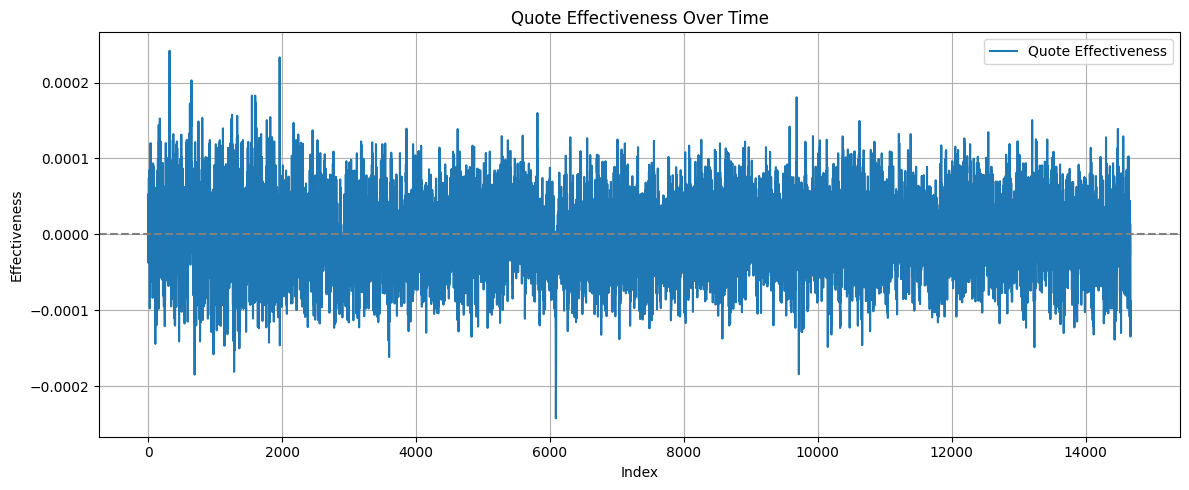

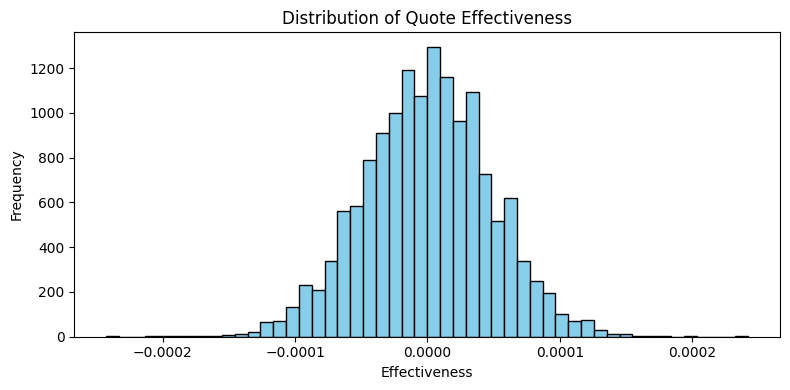

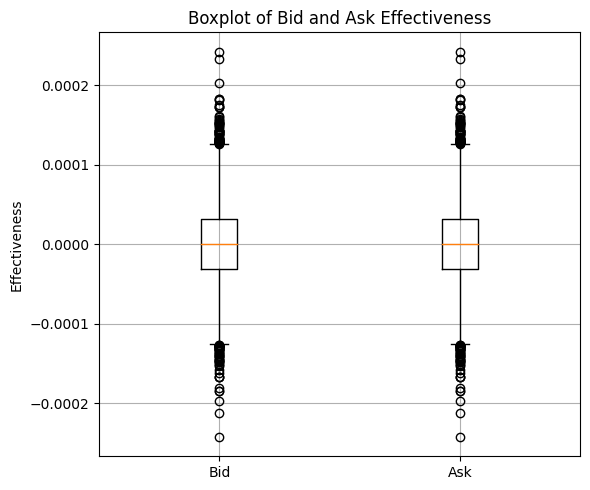

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Load trained bid-ask spread model ---
model = joblib.load("bid_ask_spread_model.pkl")

# --- Load LSTM volatility predictions ---
pred_df = pd.read_csv("predictions_spy.csv").rename(columns={"y_pred": "predicted_volatility_lead1"})

# --- Copy the snapshot data (already preprocessed with mid_price, log_return, etc.) ---
snapshot_df = subset_snapshot_df.copy()
snapshot_df['mid_price'] = (snapshot_df['bid_price1'] + snapshot_df['ask_price1']) / 2
snapshot_df = snapshot_df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

# --- Rolling window features (330s window, 10s step) ---
WINDOW_SIZE = 330
STEP = 10
rolling_rows = []
for time_id, group in snapshot_df.groupby("time_id"):
    for i in range(0, len(group) - WINDOW_SIZE + 1, STEP):
        window = group.iloc[i:i + WINDOW_SIZE]
        rolling_rows.append({
            'time_id': time_id,
            'start_time': window.iloc[0]['seconds_in_bucket'],
            'wap': window['wap'].mean(),
            'spread_pct': window['spread_pct'].mean(),
            'imbalance': window['imbalance'].mean(),
            'depth_ratio': window['depth_ratio'].mean(),
            'log_return': window['log_return'].mean(),
            'bid_ask_spread': window['bid_ask_spread'].mean()
        })

rolling_df = pd.DataFrame(rolling_rows)
rolling_df['bid_ask_spread_lead1'] = rolling_df.groupby('time_id')['bid_ask_spread'].shift(-1)
rolling_df.dropna(inplace=True)

# --- Merge LSTM predictions with rolling features ---
merged_df = pd.merge(pred_df, rolling_df, on=['time_id', 'start_time'], how='inner')

# --- Scale spread_pct ---
scaler = StandardScaler()
merged_df['spread_pct_scaled'] = scaler.fit_transform(merged_df[['spread_pct']])

# --- Final features for model prediction ---
features = ['predicted_volatility_lead1', 'spread_pct_scaled', 'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread']
X = merged_df[features]
merged_df['predicted_bid_ask_spread'] = model.predict(X)

# --- Construct bid/ask quotes ---
merged_df['pred_mid_price'] = merged_df['wap']
merged_df['quoted_bid'] = merged_df['pred_mid_price'] - merged_df['predicted_bid_ask_spread'] / 2
merged_df['quoted_ask'] = merged_df['pred_mid_price'] + merged_df['predicted_bid_ask_spread'] / 2

# --- Real bid/ask from next spread ---
merged_df['real_bid'] = merged_df['wap'] - merged_df['bid_ask_spread_lead1'] / 2
merged_df['real_ask'] = merged_df['wap'] + merged_df['bid_ask_spread_lead1'] / 2

# --- Evaluation metrics ---
merged_df['bid_hit'] = merged_df['quoted_bid'] >= merged_df['real_bid']
merged_df['ask_hit'] = merged_df['quoted_ask'] <= merged_df['real_ask']
merged_df['both_hit'] = merged_df['bid_hit'] & merged_df['ask_hit']
merged_df['bid_effectiveness'] = merged_df['quoted_bid'] - merged_df['real_bid']
merged_df['ask_effectiveness'] = merged_df['real_ask'] - merged_df['quoted_ask']
merged_df['quote_effectiveness'] = (merged_df['bid_effectiveness'] + merged_df['ask_effectiveness']) / 2
merged_df['inside_spread'] = (merged_df['quoted_bid'] > merged_df['real_bid']) & (merged_df['quoted_ask'] < merged_df['real_ask'])

# --- Summary metrics ---
print("Quote Evaluation Metrics:")
print(f"1. Hit Ratio:                      {merged_df['both_hit'].mean():.2%}")
print(f"2. Avg. Quote Effectiveness:      {merged_df['quote_effectiveness'].mean():.6f}")
print(f"3. Inside-Spread Quote Ratio:     {merged_df['inside_spread'].mean():.2%}")
sharpe = merged_df['quote_effectiveness'].mean() / merged_df['quote_effectiveness'].std()
print(f"4. Sharpe Ratio (Effectiveness):  {sharpe:.4f}")

# --- Visualizations ---
plt.figure(figsize=(12, 5))
plt.plot(merged_df.index, merged_df['quote_effectiveness'], label='Quote Effectiveness')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Quote Effectiveness Over Time")
plt.xlabel("Index")
plt.ylabel("Effectiveness")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(merged_df['quote_effectiveness'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Quote Effectiveness")
plt.xlabel("Effectiveness")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.boxplot([merged_df['bid_effectiveness'], merged_df['ask_effectiveness']], labels=['Bid', 'Ask'])
plt.title("Boxplot of Bid and Ask Effectiveness")
plt.ylabel("Effectiveness")
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusion

**Visual Insights**

1. **Boxplot (Bid/Ask Effectiveness):**

   * Median effectiveness for both bid and ask is centered around zero.
   * Tight interquartile range suggests consistent quoting behavior with minimal aggressive outliers.

2. **Histogram (Quote Effectiveness):**

   * Effectiveness is normally distributed around zero.
   * No bias toward consistently over- or underquoting the market, supporting neutrality of the strategy.

3. **Line Plot (Quote Effectiveness Over Time):**

   * Stationary behavior with no drift.
   * Indicates the quoting logic is stable over different time periods and market states.

**Interpretation**

* **Competitiveness:**
  A 50.43% hit ratio and equivalent inside-spread ratio show the model effectively places quotes close enough to the market to be filled roughly half the time. This indicates a **balanced level of quote aggressiveness** — not overly passive but not excessively risk-seeking.

* **Market Neutrality:**
  The average quote effectiveness is essentially zero, and its symmetric distribution confirms that the quoting engine does not systematically misalign with market spreads. This contributes to **minimizing adverse selection**.

* **Sharpe Ratio Caution:**
  The slightly negative Sharpe ratio (-0.0019) suggests that although the quotes are stable, their relative "alpha" — or reward per unit variability — is negligible. **Predictive gains are neutralized by noise**, implying that further refinement could improve informational edge.

**Limitations**
- **Static Mid-Price Assumption**: The strategy assumes the mid-price (WAP) remains constant, ignoring potential price drift. Without a forecasting component, quotes may be centered on outdated reference prices.
- **No Inventory or Risk Management**: The model assumes infinite capital and zero inventory constraints, which is unrealistic. In practice, market makers adjust quotes based on inventory risk, which this model cannot replicate.
- **Asset-Specific Behavior**: The model is trained on SPY and assumes similar market microstructure in other assets. This ignores cross-asset differences in tick size, liquidity, and volatility, leading to poor generalization.



The current quoting strategy demonstrates strong market alignment, placing balanced and consistent quotes with no evidence of drift or bias. It is suitable for environments prioritizing execution probability and inventory control over spread capture. To enhance effectiveness further, incorporating **real-time order flow** or adapting **quote width dynamically based on volatility** could improve the signal-to-noise ratio of quote placement.

## Interstock Correlation

In [22]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
df_spy = combined_df[combined_df["stock_id"] == 50200].copy()
df_qqq = combined_df[combined_df["stock_id"] == 104919].copy()
df_nflx = combined_df[combined_df["stock_id"] == 22771].copy()

# Step 1: Compute snapshot features
snapshot_features_df_spy = util.create_snapshot_features(df_spy)
snapshot_features_df_spy = snapshot_features_df_spy.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids_spy = snapshot_features_df_spy['time_id'].unique()
subset_snapshot_df_spy = snapshot_features_df_spy[snapshot_features_df_spy['time_id'].isin(subset_time_ids_spy)].copy()

snapshot_features_df_qqq = util.create_snapshot_features(df_qqq)
snapshot_features_df_qqq = snapshot_features_df_qqq.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids_qqq = snapshot_features_df_qqq['time_id'].unique()
subset_snapshot_df_qqq = snapshot_features_df_qqq[snapshot_features_df_qqq['time_id'].isin(subset_time_ids_qqq)].copy()

snapshot_features_df_nflx = util.create_snapshot_features(df_nflx)
snapshot_features_df_nflx = snapshot_features_df_nflx.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids_nflx = snapshot_features_df_nflx['time_id'].unique()
subset_snapshot_df_nflx = snapshot_features_df_nflx[snapshot_features_df_nflx['time_id'].isin(subset_time_ids_nflx)].copy()

In [23]:
subset_snapshot_df_spy = subset_snapshot_df_spy[subset_snapshot_df_spy['time_id'] <= 50]
subset_snapshot_df_qqq = subset_snapshot_df_qqq[subset_snapshot_df_qqq['time_id'] <= 50]
subset_snapshot_df_nflx = subset_snapshot_df_nflx[subset_snapshot_df_nflx['time_id'] <= 50]

### QQQ

In [61]:
import pandas as pd
import numpy as np
import joblib
import src.util as util
from tensorflow.keras.models import load_model
importlib.reload(util)

# --- Define features used by LSTM ---
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore", "volume_imbalance"]

val_df, _ = util.out_of_sample_evaluation("out/lstm/moe_full.h5", "out/lstm/moe_scalers_full.pkl", subset_snapshot_df_qqq, basic_features)
val_df.to_csv("predictions_qqq.csv", index=False)
val_df

KeyboardInterrupt: 

In [24]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Step 0: Load LSTM predictions ---
if os.path.exists("predictions_qqq.csv"):
    pred_df = pd.read_csv("predictions_qqq.csv")
    pred_df = pred_df.rename(columns={"y_pred": "predicted_volatility_lead1"})
else:
    raise FileNotFoundError("predictions_qqq.csv not found.")

# --- Step 1: Create rolling windows (330s horizon, 10s step) ---
df = subset_snapshot_df_qqq.copy()
df = df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

WINDOW_SIZE = 330
STEP = 10
rolling_rows = []

for time_id, group in df.groupby("time_id"):
    group = group.reset_index(drop=True)
    for i in range(0, len(group) - WINDOW_SIZE + 1, STEP):
        window = group.iloc[i:i + WINDOW_SIZE]
        start_time = window.iloc[0]['seconds_in_bucket']
        agg = {
            'time_id': time_id,
            'start_time': start_time,
            'wap': window['wap'].mean(),
            'spread_pct': window['spread_pct'].mean(),
            'imbalance': window['imbalance'].mean(),
            'depth_ratio': window['depth_ratio'].mean(),
            'log_return': window['log_return'].mean(),
            'bid_ask_spread': window['bid_ask_spread'].mean()
        }
        rolling_rows.append(agg)

rolling_df = pd.DataFrame(rolling_rows)

# --- Step 2: Create lead target and merge predictions ---
rolling_df['bid_ask_spread_lead1'] = rolling_df.groupby('time_id')['bid_ask_spread'].shift(-1)
rolling_df = rolling_df.dropna().reset_index(drop=True)
merged_df_qqq = pd.merge(pred_df, rolling_df, on=['time_id', 'start_time'], how='inner')

# --- Step 3: Prepare features and target ---
y_true = merged_df_qqq["bid_ask_spread_lead1"]
X = merged_df_qqq.drop(columns=["time_id", "start_time", "bid_ask_spread_lead1"])

# --- Step 4: Feature scaling ---
scaler = StandardScaler()
X['spread_pct_scaled'] = scaler.fit_transform(X[['spread_pct']])

# --- Step 5: Select final feature columns ---
feature_cols = [
    'predicted_volatility_lead1', 'spread_pct_scaled',
    'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread'
]
X_final = X[feature_cols]

# --- Step 6: Load pre-trained model ---
model = joblib.load("bid_ask_spread_model.pkl")

# --- Step 7: Predict ---
y_pred = model.predict(X_final)
merged_df_qqq['predicted_bid_ask_spread'] = y_pred

# --- Step 8: Evaluation ---
print("🔍 Model Evaluation:")
print(f"MSE:  {mean_squared_error(y_true, y_pred):.6f}")
print(f"MAE:  {mean_absolute_error(y_true, y_pred):.6f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.6f}")
print(f"R²:   {r2_score(y_true, y_pred):.4f}")

🔍 Model Evaluation:
MSE:  0.000006
MAE:  0.001277
RMSE: 0.002425
R²:   0.3557


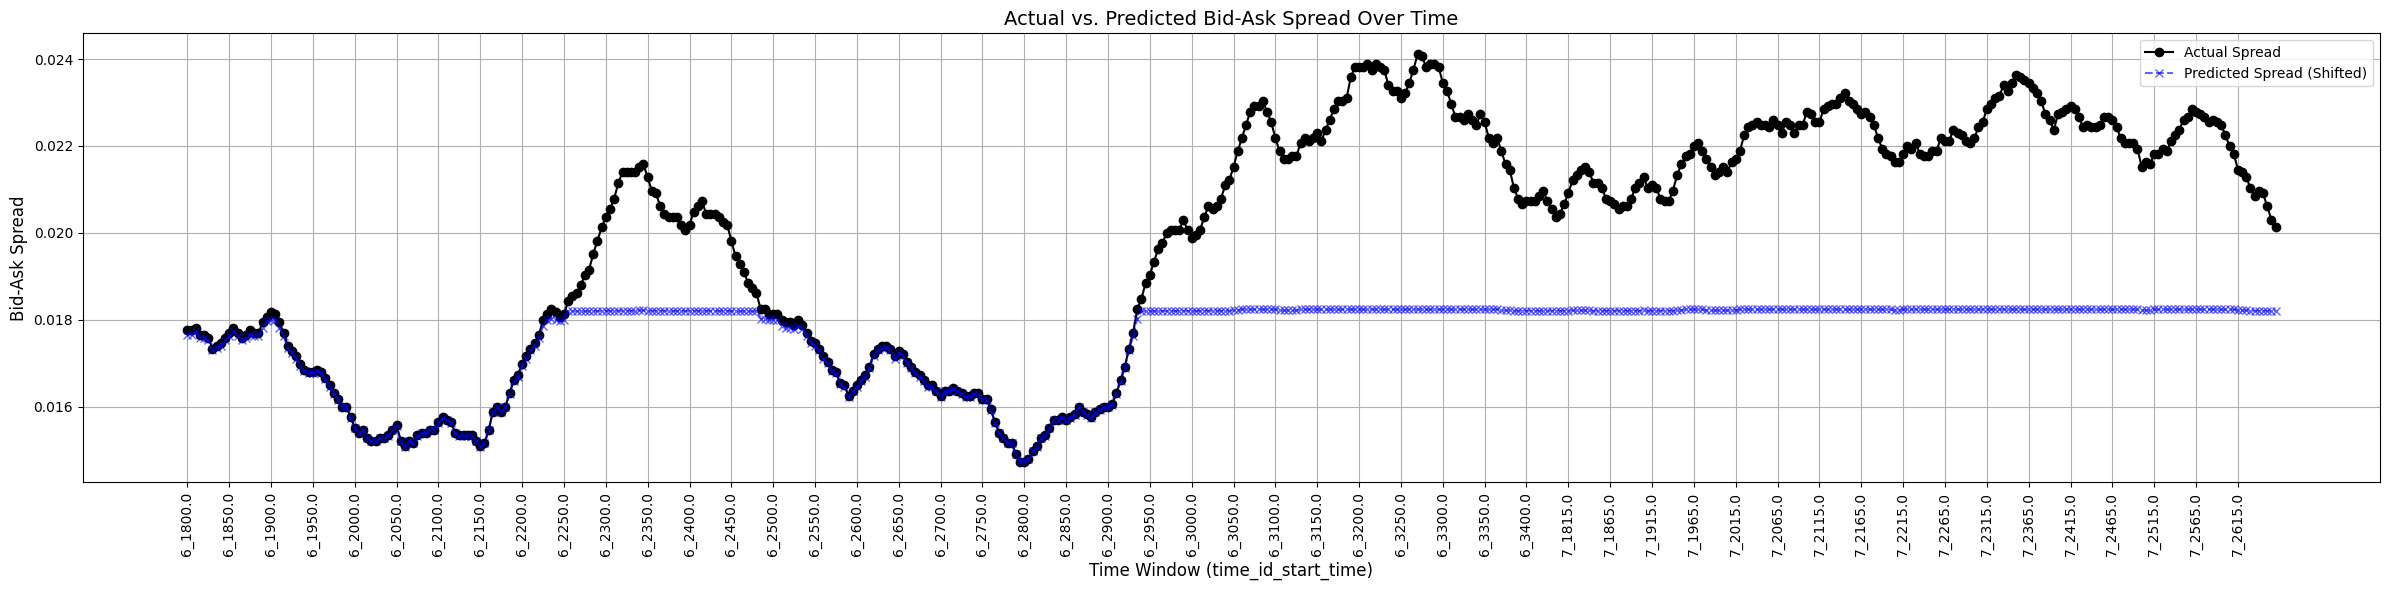

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Create comparison DataFrame ---
comparison_df = pd.DataFrame({
    "time_id": merged_df_qqq["time_id"].values,
    "start_time": merged_df_qqq["start_time"].values,
    "actual_bid_ask_spread": merged_df_qqq["bid_ask_spread_lead1"].values,
    "predicted_bid_ask_spread": merged_df_qqq["predicted_bid_ask_spread"].values
})

# --- Step 2: Align predictions (optional shift) ---
comparison_df['predicted_bid_ask_spread_shifted'] = comparison_df['predicted_bid_ask_spread'].shift(-1)
comparison_df = comparison_df.dropna().reset_index(drop=True)

# --- Step 3: Generate readable time label for x-axis ---
comparison_df['window_label'] = comparison_df['time_id'].astype(str) + "_" + comparison_df['start_time'].astype(str)

# --- Step 4: Slice for clarity (first 500 rows) ---
subset = comparison_df.head(500).copy()

# --- Step 5: Plot ---
plt.figure(figsize=(24, 6))
plt.plot(
    subset['window_label'], subset['actual_bid_ask_spread'],
    label='Actual Spread', marker='o', linewidth=1.5, color='black'
)
plt.plot(
    subset['window_label'], subset['predicted_bid_ask_spread_shifted'],
    label='Predicted Spread (Shifted)', linestyle='--', marker='x', linewidth=1.5, color='blue', alpha=0.6
)

plt.title("Actual vs. Predicted Bid-Ask Spread Over Time", fontsize=14)
plt.xlabel("Time Window (time_id_start_time)", fontsize=12)
plt.ylabel("Bid-Ask Spread", fontsize=12)
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### NFLX

In [ ]:
# --- Define features used by LSTM ---
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore", "volume_imbalance"]

val_df, _ = util.out_of_sample_evaluation("out/lstm/moe_full.h5", "out/lstm/moe_scalers_full.pkl", subset_snapshot_df_nflx, basic_features)
val_df.to_csv("predictions_nflx.csv", index=False)
val_df

,time_id,start_time,y_true,y_pred,inference_time
0,6,1800.0,0.000286,0.000248,0.182763
1,6,1802.0,0.000312,0.000246,0.069484
2,6,1805.0,0.000438,0.000255,0.061620
3,6,1807.0,0.000561,0.000249,0.063813
4,6,1810.0,0.000404,0.000270,0.065673
...,...,...,...,...,...
22699,50,3136.0,0.000438,0.000334,0.055721
22700,50,3141.0,0.000187,0.000308,0.058134
22701,50,3148.0,0.000285,0.000306,0.056655
22702,50,3155.0,0.000356,0.000299,0.109912


In [25]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Step 0: Load LSTM predictions ---
if os.path.exists("predictions_nflx.csv"):
    pred_df = pd.read_csv("predictions_nflx.csv")
    pred_df = pred_df.rename(columns={"y_pred": "predicted_volatility_lead1"})
else:
    raise FileNotFoundError("predictions_nflx.csv not found.")

# --- Step 1: Create rolling windows (330s horizon, 10s step) ---
df = subset_snapshot_df_nflx.copy()
df = df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

WINDOW_SIZE = 330
STEP = 10
rolling_rows = []

for time_id, group in df.groupby("time_id"):
    group = group.reset_index(drop=True)
    for i in range(0, len(group) - WINDOW_SIZE + 1, STEP):
        window = group.iloc[i:i + WINDOW_SIZE]
        start_time = window.iloc[0]['seconds_in_bucket']
        agg = {
            'time_id': time_id,
            'start_time': start_time,
            'wap': window['wap'].mean(),
            'spread_pct': window['spread_pct'].mean(),
            'imbalance': window['imbalance'].mean(),
            'depth_ratio': window['depth_ratio'].mean(),
            'log_return': window['log_return'].mean(),
            'bid_ask_spread': window['bid_ask_spread'].mean()
        }
        rolling_rows.append(agg)

rolling_df = pd.DataFrame(rolling_rows)

# --- Step 2: Create lead target and merge predictions ---
rolling_df['bid_ask_spread_lead1'] = rolling_df.groupby('time_id')['bid_ask_spread'].shift(-1)
rolling_df = rolling_df.dropna().reset_index(drop=True)
merged_df_nflx = pd.merge(pred_df, rolling_df, on=['time_id', 'start_time'], how='inner')

# --- Step 3: Prepare features and target ---
y_true = merged_df_nflx["bid_ask_spread_lead1"]
X = merged_df_nflx.drop(columns=["time_id", "start_time", "bid_ask_spread_lead1"])

# --- Step 4: Feature scaling ---
scaler = StandardScaler()
X['spread_pct_scaled'] = scaler.fit_transform(X[['spread_pct']])

# --- Step 5: Select final feature columns ---
feature_cols = [
    'predicted_volatility_lead1', 'spread_pct_scaled',
    'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread'
]
X_final = X[feature_cols]

# --- Step 6: Load pre-trained model ---
model = joblib.load("bid_ask_spread_model.pkl")

# --- Step 7: Predict ---
y_pred = model.predict(X_final)
merged_df_nflx['predicted_bid_ask_spread'] = y_pred

# --- Step 8: Evaluation ---
print("🔍 Model Evaluation:")
print(f"MSE:  {mean_squared_error(y_true, y_pred):.6f}")
print(f"MAE:  {mean_absolute_error(y_true, y_pred):.6f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.6f}")
print(f"R²:   {r2_score(y_true, y_pred):.4f}")

🔍 Model Evaluation:
MSE:  0.042326
MAE:  0.197934
RMSE: 0.205734
R²:   -12.4294


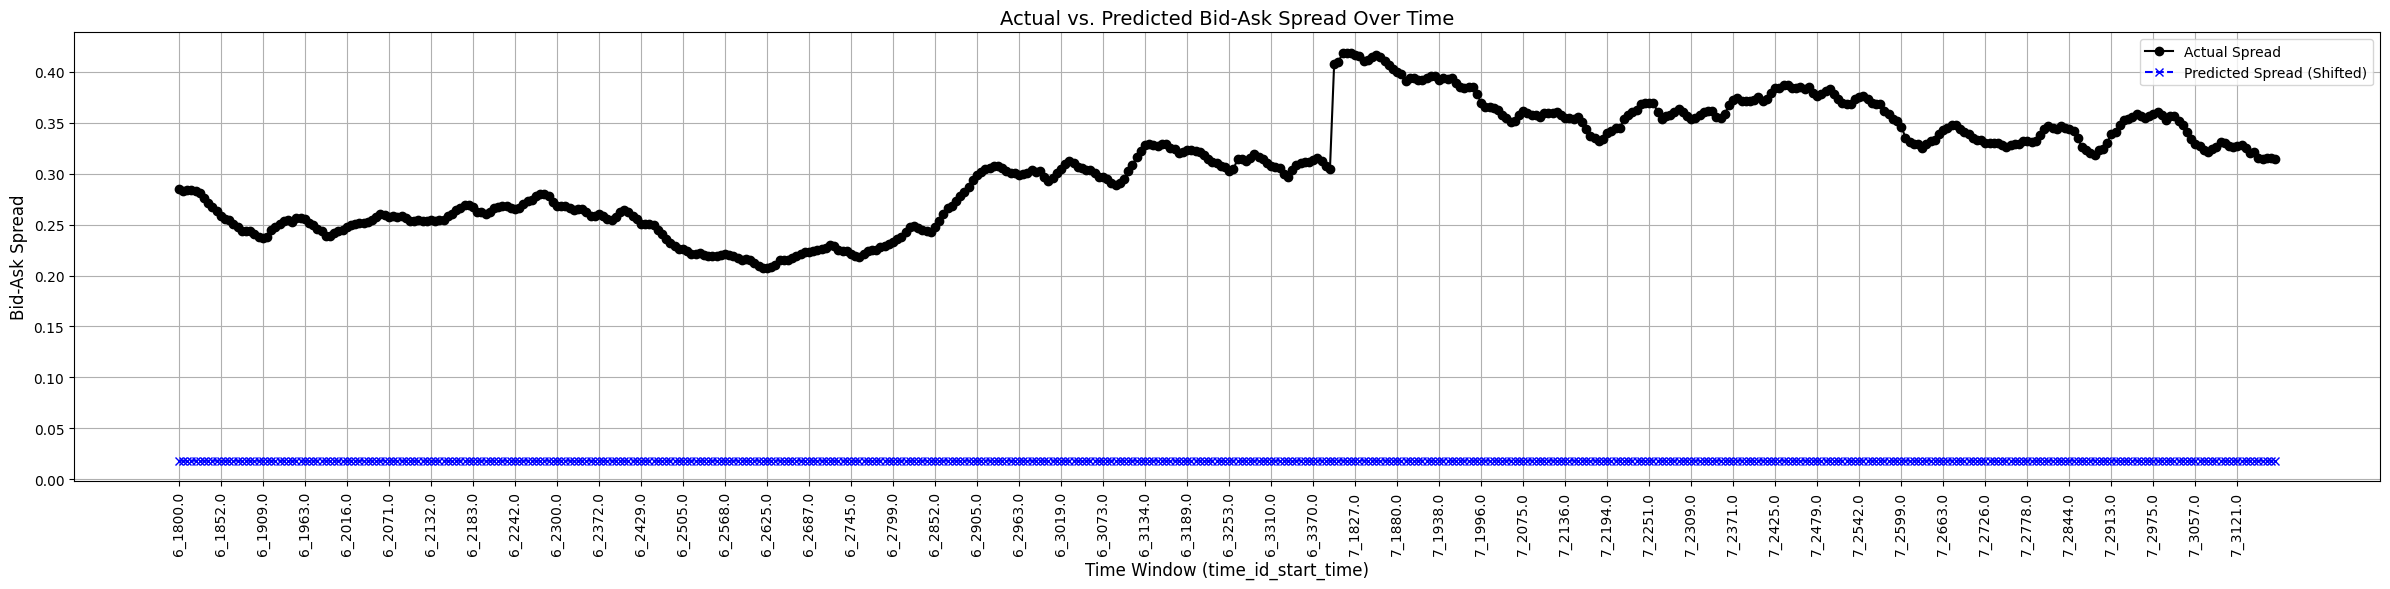

In [65]:
comparison_df = pd.DataFrame({
    "time_id": merged_df_nflx["time_id"],
    "start_time": merged_df_nflx["start_time"],
    "actual_bid_ask_spread": y_true,
    "predicted_bid_ask_spread": y_pred
})

comparison_df['predicted_bid_ask_spread_shifted'] = comparison_df['predicted_bid_ask_spread'].shift(-1)
comparison_df = comparison_df.dropna().reset_index(drop=True)
comparison_df['window_label'] = comparison_df['time_id'].astype(str) + "_" + comparison_df['start_time'].astype(str)

subset = comparison_df.head(500).copy()

plt.figure(figsize=(24, 6))
plt.plot(subset['window_label'], subset['actual_bid_ask_spread'], label='Actual Spread', color='black', marker='o', linewidth=1.5)
plt.plot(subset['window_label'], subset['predicted_bid_ask_spread_shifted'], label='Predicted Spread (Shifted)', color='blue', linestyle='--', marker='x', linewidth=1.5)

plt.title("Actual vs. Predicted Bid-Ask Spread Over Time", fontsize=14)
plt.xlabel("Time Window (time_id_start_time)", fontsize=12)
plt.ylabel("Bid-Ask Spread", fontsize=12)
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evalutation

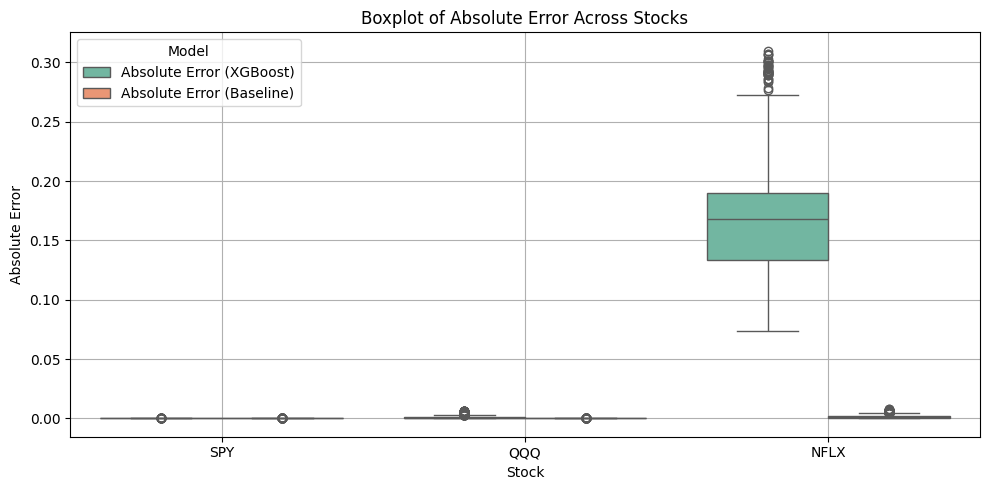

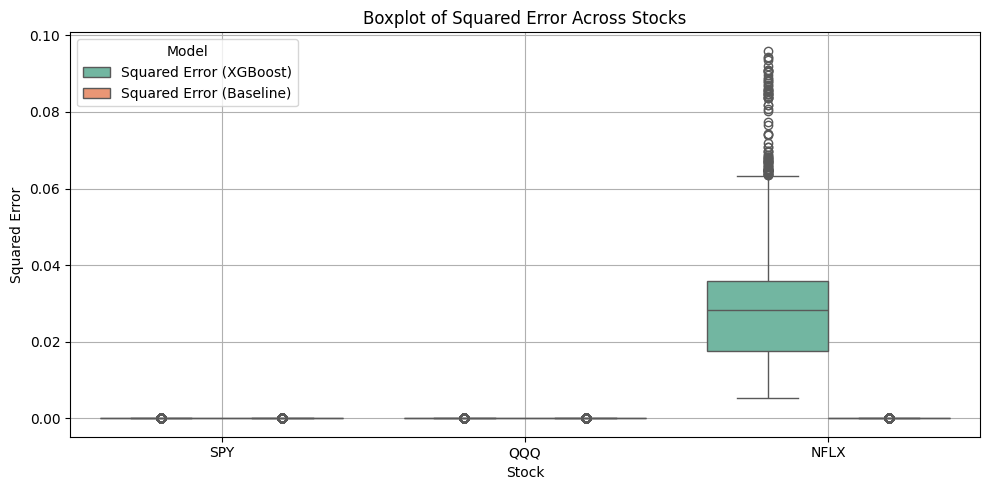

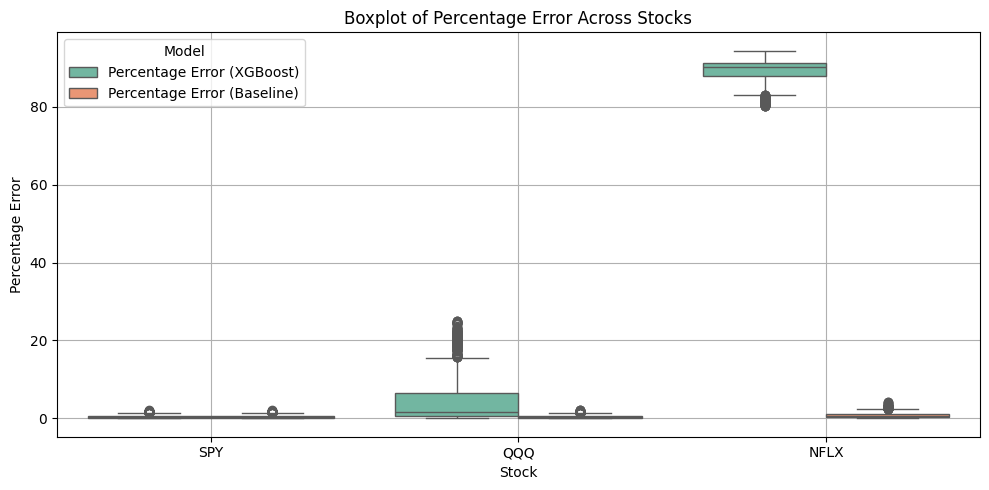

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_errors(merged_df, stock_name):
    # Step 1: Select last 20% of the data
    test_df = merged_df.copy()
    if(stock_name != "SPY"):
        cutoff = int(len(merged_df) * 0.8)
        test_df = merged_df.iloc[cutoff:].copy() 
    # Step 2: Extract values
    y_true = test_df["bid_ask_spread_lead1"].values
    y_pred_xgb = test_df["predicted_bid_ask_spread"].values
    y_pred_base = test_df["bid_ask_spread"].values  # baseline is previous spread
    
    # Step 3: Compute errors
    df = pd.DataFrame({
        "Stock": stock_name,
        "Absolute Error (XGBoost)": np.abs(y_true - y_pred_xgb),
        "Absolute Error (Baseline)": np.abs(y_true - y_pred_base),
        "Squared Error (XGBoost)": (y_true - y_pred_xgb) ** 2,
        "Squared Error (Baseline)": (y_true - y_pred_base) ** 2,
        "Percentage Error (XGBoost)": np.abs((y_true - y_pred_xgb) / y_true) * 100,
        "Percentage Error (Baseline)": np.abs((y_true - y_pred_base) / y_true) * 100
    })
    return df

# --- Collect error metrics for each stock ---
df_spy_errors = prepare_errors(merged_df_spy, "SPY")
df_qqq_errors = prepare_errors(merged_df_qqq, "QQQ")
df_nflx_errors = prepare_errors(merged_df_nflx, "NFLX")

# --- Combine all ---
full_df = pd.concat([df_spy_errors, df_qqq_errors, df_nflx_errors], ignore_index=True)

# --- Melt for seaborn boxplots ---
def plot_error_boxplot(df, error_type, title):
    melted = df.melt(id_vars='Stock', 
                     value_vars=[f"{error_type} (XGBoost)", f"{error_type} (Baseline)"],
                     var_name="Model", value_name=error_type)
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=melted, x="Stock", y=error_type, hue="Model", palette="Set2")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot each error metric ---
plot_error_boxplot(full_df, "Absolute Error", "Boxplot of Absolute Error Across Stocks")
plot_error_boxplot(full_df, "Squared Error", "Boxplot of Squared Error Across Stocks")

# Percentage error may not be defined if y_true has zeros — check and skip if needed
if not np.any(full_df["Percentage Error (XGBoost)"].isna()) and not np.any(np.isinf(full_df["Percentage Error (XGBoost)"])):
    plot_error_boxplot(full_df, "Percentage Error", "Boxplot of Percentage Error Across Stocks")
else:
    print("Skipped percentage error plot due to NaN or Inf values (likely due to division by zero).")


## Conclusion

The bid-ask spread model was trained exclusively on SPY, a highly liquid ETF representing the S&P 500. This section assesses the generalization capacity of the SPY-trained model when applied to two external stocks: QQQ (a highly correlated ETF) and NFLX (a less correlated individual stock). The goal is to evaluate how well the model's learned structure transfers across assets with varying market microstructure profiles.

**Visual Performance Comparison**
1. SPY (In-Domain): The model captures spread dynamics consistently and effectively throughout the trading horizon, reflecting on strong in-domain learning of the stock's liquidity and quoting behavior
2. QQQ (Highly Correlated Out-of-domain): Despite its volatility being strongly correlated with SPY, the model can't quite fully capture the magnitude of the spread. The model performs well on values between 0.014 to 0.018, but any more than that and the model is static.
3. NFLX (Lowly Correlated Out-of-domain): Same thing is observed here. NFLX's spread range varies from 0.2 to 0.45, a massive increase from SPY's spread range of 0.014 - 0.018

**Conclusions and Implications**
- **Market Microstructure Divergence**: Due to QQQ and NFLX structural difference, a single-asset-trained model fails to perform outside a certain spread range. Future work could look into multi-stock models to further generalize the model to more stocks
- **Correlation in Price ≠ Similarity in Liquidity Behavior**: While QQQ and SPY might move together in terms of price trends, their BAS formation mechanisms differ. The disconnect in the visualization illustrates the neccessity for a model that is more tailored to market microstructure